In [1]:
import io
import re
import contextlib
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost
import random
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix

# Data Preparation
### Dataset Fields

- **id**: ID number
- **age**: Patient age in days
- **gender**: Patient gender (Men = 2, Women = 1)
- **height**: Patient height in centimeters
- **weight**: Patient weight in kilograms
- **ap_hi**: Patient systolic blood pressure
- **ap_lo**: Patient diastolic blood pressure
- **cholesterol**: Patient cholesterol levels  
  - 1: Normal  
  - 2: Above normal  
  - 3: Well above normal
- **gluc**: Patient glucose levels  
  - 1: Normal  
  - 2: Above normal  
  - 3: Well above normal
- **smoke**: Whether the patient smokes (1 = Yes, 0 = No)
- **alco**: Whether the patient consumes alcohol (1 = Yes, 0 = No)
- **active**: Whether the patient exercises (1 = Yes, 0 = No)
- **cardio**: Presence or absence of cardiovascular disease (1 = Disease present, 0 = Disease absent)

In [2]:
df = pd.read_csv('../dataset/cardio_vascular_disease_dataset.csv',sep=';')
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


### Cleaning Data

1. Mapping numerical values to categorical representations
   - Cholesterol
   - Glucose
   - gender
   - alco
   - smoke
   - active
2. Check for null values
3. Drop the `id` column

In [3]:
# Mapping values
cholesterol_levels = {
    1:'normal',
    2: 'above_normal',
    3: 'well_above_normal'
}

In [4]:
df.cholesterol = df.cholesterol.map(cholesterol_levels)

In [5]:
glucose_levels = {
    1:'normal',
    2: 'above_normal',
    3: 'well_above_normal'
}

In [6]:
df.gluc = df.gluc.map(glucose_levels)

In [7]:
gender_values = {
    1:'female',
    2: 'male'
}

In [8]:
df.gender = df.gender.map(gender_values)

In [9]:
smoke_values = {
    0:'no',
    1: 'yes'
}

In [10]:
df.smoke = df.smoke.map(smoke_values)

In [11]:
active_values = {
    0:'no',
    1: 'yes'
}

In [12]:
df.active = df.active.map(active_values)

In [13]:
alco_values = {
    0:'no',
    1: 'yes'
}

In [14]:
df.alco = df.alco.map(alco_values)

In [15]:
df[['age','weight','ap_hi','ap_lo',]]

,age,weight,ap_hi,ap_lo
0,18393,62.0,110,80
1,20228,85.0,140,90
2,18857,64.0,130,70
3,17623,82.0,150,100
4,17474,56.0,100,60
...,...,...,...,...
69995,19240,76.0,120,80
69996,22601,126.0,140,90
69997,19066,105.0,180,90
69998,22431,72.0,135,80


In [16]:
df = df.drop('id',axis=1)

In [17]:
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## Exploratory Data Analysis

In [18]:
df.describe()

,age,height,weight,ap_hi,ap_lo,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414,0.499700
std,2467.251667,8.210126,14.395757,154.011419,188.472530,0.500003
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000,0.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000,0.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000,0.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000,1.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000,1.000000


In [19]:
df.ap_lo.max()

11000

In [27]:
df.loc[df['ap_lo'] >= 1000, 'ap_lo'] = df['ap_lo'] / 10

In [33]:
df.loc[df['ap_lo'] >= 1000, 'ap_lo'] = df['ap_lo'] / 10

In [34]:
df.loc[df['ap_lo'] >= 300, 'ap_lo'] = df['ap_lo'] / 10

In [ ]:
df

In [32]:
df.ap_lo.value_counts()

ap_lo
80.0     34847
90.0     14316
70.0     10245
100.0     4751
60.0      2727
         ...  
118.0        1
56.0         1
182.0        1
9.0          1
602.0        1
Name: count, Length: 141, dtype: int64

In [34]:
df.ap_lo

0        8
1        9
2        7
3        1
4        6
        ..
69995    8
69996    9
69997    9
69998    8
69999    8
Name: ap_lo, Length: 70000, dtype: int64

In [33]:
df['ap_lo'].max()

9011

In [19]:
df.dtypes

age              int64
gender          object
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol     object
gluc            object
smoke           object
alco            object
active          object
cardio           int64
dtype: object

In [20]:
numerical_cols = df.select_dtypes(include=['int64', 'float64'])
numerical_cols_list = numerical_cols.drop('cardio',axis=1).columns.values
numerical_cols_list

array(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], dtype=object)

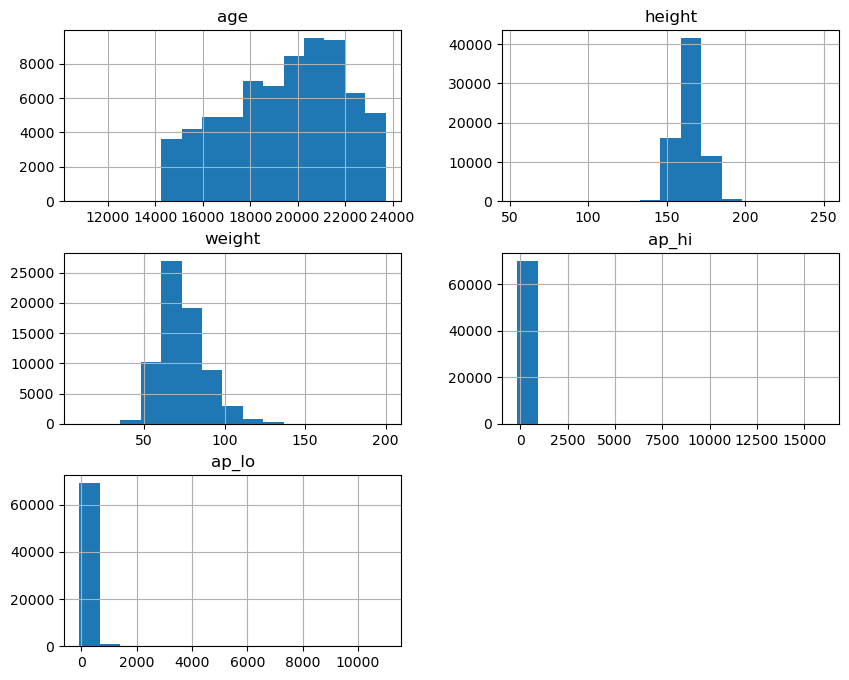

In [21]:
# Histograms showing distribution of each numerical columns
df[numerical_cols_list].hist(bins=15,figsize=(10,8))
plt.show()

In [22]:
# Correlation matrix for numerical columns
correlation = numerical_cols.drop('cardio',axis=1).corr()
correlation

,age,height,weight,ap_hi,ap_lo
age,1.000000,-0.081515,0.053684,0.020764,0.017647
height,-0.081515,1.000000,0.290968,0.005488,0.006150
weight,0.053684,0.290968,1.000000,0.030702,0.043710
ap_hi,0.020764,0.005488,0.030702,1.000000,0.016086
ap_lo,0.017647,0.006150,0.043710,0.016086,1.000000


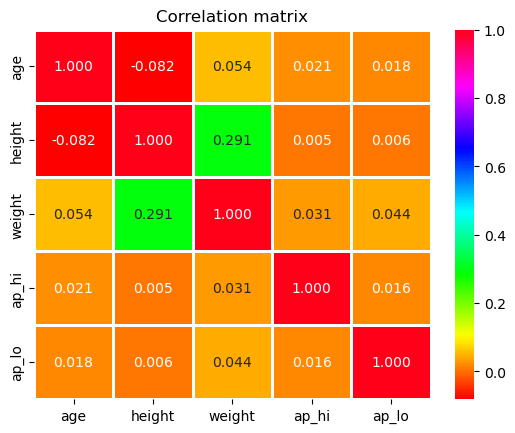

In [23]:
sns.heatmap(correlation,annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.title("Correlation matrix")
plt.show()

1. Height and Weight (0.29):
- There is a moderate positive correlation (0.29) between height and weight, indicating that taller individuals tend to have higher weights. This is the strongest correlation observed in this matrix.

2. Other Variables and Weak Correlations:
- The rest of the correlations between variables are quite low, suggesting minimal linear relationships between these features. For example, `age` shows weak correlations with all other variables, with the highest correlation being only 0.054 with `weight`. This means `age` does not have a strong linear relationship with other variables in this dataset.
- Blood Pressure Variables (`ap_hi` and `ap_lo`) also show low correlations with each other (0.016), which is unusual, as systolic and diastolic blood pressures are often expected to be correlated. This low correlation might suggest inconsistencies in data recording or could indicate that these variables are independent in this specific dataset.

3. No Strong Predictors:
- The lack of strong correlations suggests that none of these variables alone has a significant linear relationship with others. This could imply that these features may contribute only weakly to each other in terms of prediction if using linear models.

**Note**: Given the weak relationships, this dataset might benefit from more complex, non-linear analysis techniques, as linear models may not capture significant patterns effectively.

Therefore the choice is to test
1. Decision tree
2. Random forest
3. XGBoost

The best performing model will be based on the best prediction performance.

In [24]:
# Analyzing categorical Features
categorical_cols = list(df.select_dtypes(include=['object']).columns.values)
categorical_cols.append('cardio')
categorical_cols

['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

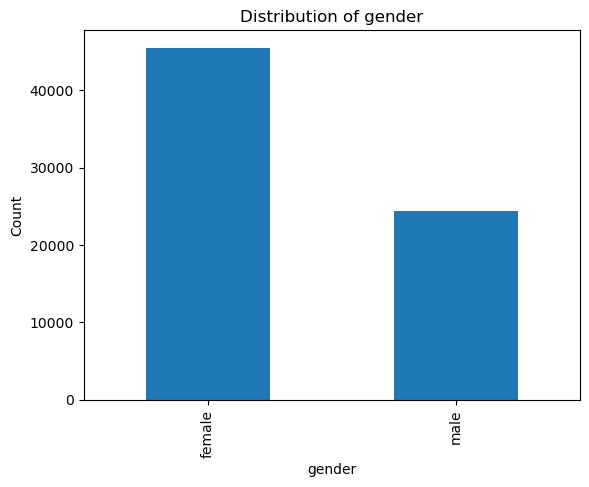

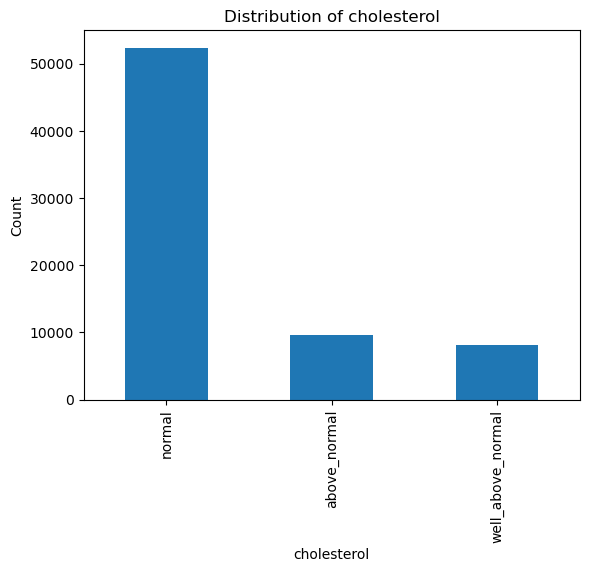

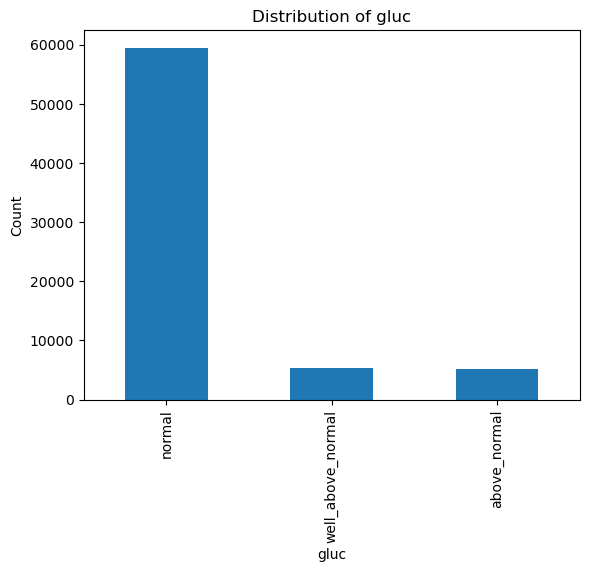

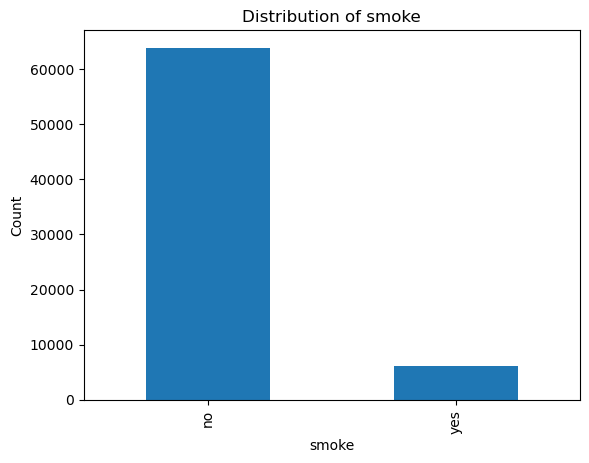

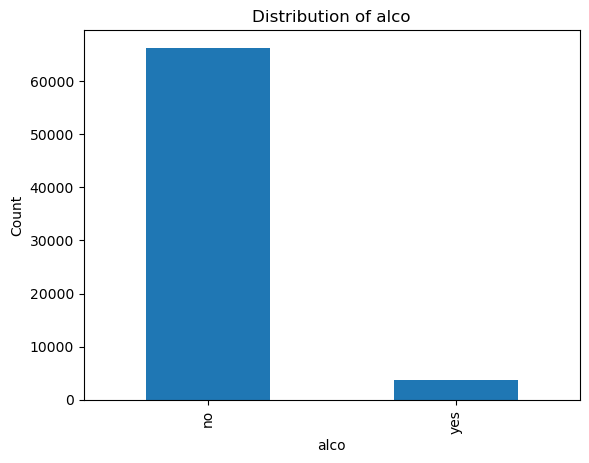

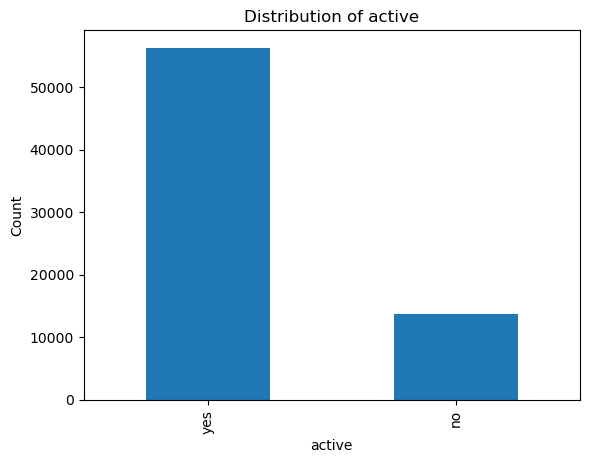

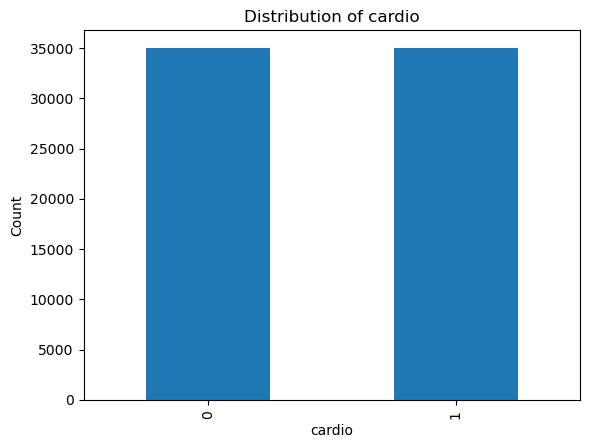

In [25]:
# Plot barcharts for categorical features
for col in categorical_cols:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

## Data Pre-processing
Split dataset into
1. Full Training dataset (80% of dataset) 
2. Training dataset (60% of Dataset)
3. Validation set (20% of Dataset)
4. Testing set (20% of Dataset)

In [26]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1,shuffle=True)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1,shuffle=True)

In [27]:
df_full_train.shape,df_train.shape,df_val.shape,df_test.shape

((56000, 12), (42000, 12), (14000, 12), (14000, 12))

In [28]:
# Define Training features and prediction values
y_train = df_train.cardio.values
y_val = df_val.cardio.values
y_test = df_test.cardio.values
y_full_train = df_full_train.cardio.values

df_full_train = df_full_train.drop('cardio',axis=1)
df_train = df_train.drop('cardio',axis=1)
df_val = df_val.drop('cardio',axis=1)
df_test = df_test.drop('cardio',axis=1)

### Onehot encoding
- `X_train` - Feature matrix
- `X_val` - Validation matrix
- `y_train` - training target vairable
- `y_val` - validation target vairable
- `y_test` - testing target vairable

In [29]:
dict_full_train = df_full_train.to_dict(orient='records')
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')

In [30]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
X_train = dv.fit_transform(dict_train)
X_val = dv.fit_transform(dict_val)
X_test = dv.fit_transform(dict_test)

### Decision Trees

In [31]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [32]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_pred)

0.9999999716549576

In [33]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.6367617085955009

Overfitting detected

#### Decision tree Parameter tuning
1. `max_depth` - Control the maximum depth of the tree, minimizing complex patterns that might overfit the data
2. `min_samples_split`- Minimum number of samples required to split the internal node
3. `min_samples_leaf` - Minimum number of samples required to split an internal node

In [34]:
max_depths = np.arange(1,20,1)
scores = []
for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth,)
    dt.fit(X_train,y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    scores.append((depth,auc))

In [35]:
df_scores = pd.DataFrame(scores,columns=['depth','auc'])
df_scores.sort_values('auc',ascending=False)

,depth,auc
5,6,0.789253
4,5,0.788061
6,7,0.787677
7,8,0.785940
3,4,0.784077
8,9,0.783556
9,10,0.778169
2,3,0.775494
10,11,0.766994
1,2,0.764334


Text(0, 0.5, 'ROC area under curve')

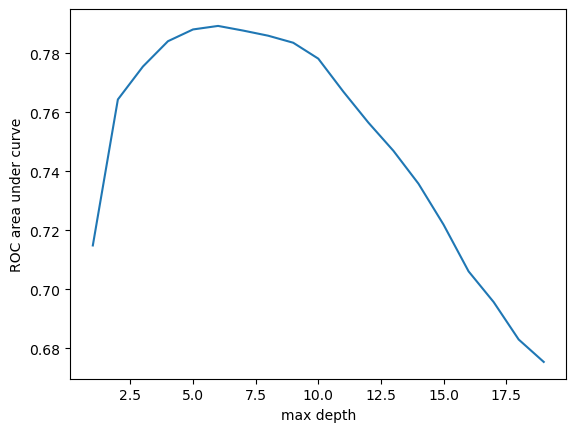

In [36]:
plt.plot(df_scores.depth,df_scores.auc)
plt.xlabel('max depth')
plt.ylabel('ROC area under curve')

Best max_depth - 6 prediction - 0.789253

In [37]:
min_samples = np.arange(1,200,1)
scores = []
for leaf in min_samples:
    dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=leaf)
    dt.fit(X_train,y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    scores.append((leaf,6,auc))

In [38]:
df_scores = pd.DataFrame(scores,columns=['leaf','depth','auc'])

In [39]:
df_scores.sort_values('auc',ascending=False)

,leaf,depth,auc
174,175,6,0.791076
171,172,6,0.791076
168,169,6,0.791074
169,170,6,0.791065
170,171,6,0.791065
...,...,...,...
1,2,6,0.789253
0,1,6,0.789253
2,3,6,0.789238
3,4,6,0.789153


Best Max Samples Leaf - 172, prediction - 0.791076

In [40]:
dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=172)
dt.fit(X_train,y_train)
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.7910756368020255

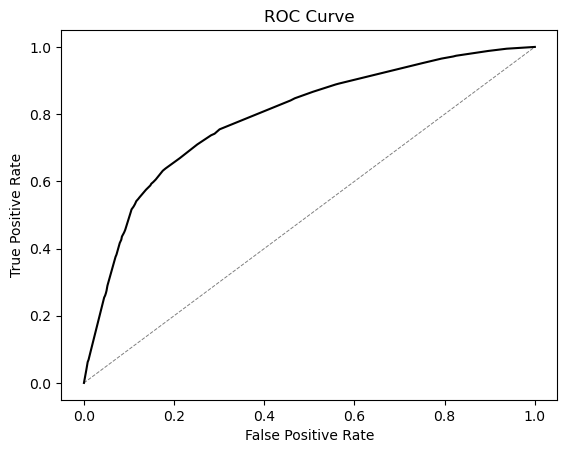

In [41]:
fpr,tpr,_ = roc_curve(y_val,y_pred)
plt.plot(fpr,tpr,color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Random Forest
- `rf` - Random Forest classifier instance
- `n_estimators` - Number of trees in the forest
- `n_jobs` - The number of jobs to run in parallel
- `max_depth` - The maximum depth of the tree.
- `min_leaf_size` - The minimum number of samples required to be at a leaf node. 

In [42]:
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [43]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.7484740470133237

In [44]:
aucs = []

for i in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    aucs.append((i,auc))

In [45]:
df_aucs= pd.DataFrame(aucs,columns=['n_estimator','auc'])
df_aucs.sort_values('auc',ascending=False)

,n_estimator,auc
13,140,0.771969
18,190,0.771722
16,170,0.771678
19,200,0.771522
17,180,0.771093
12,130,0.770942
9,100,0.770556
15,160,0.770343
10,110,0.770277
14,150,0.770059


Best N Estimator value - 200

Text(0.5, 1.0, 'Number of trees vs. AUC')

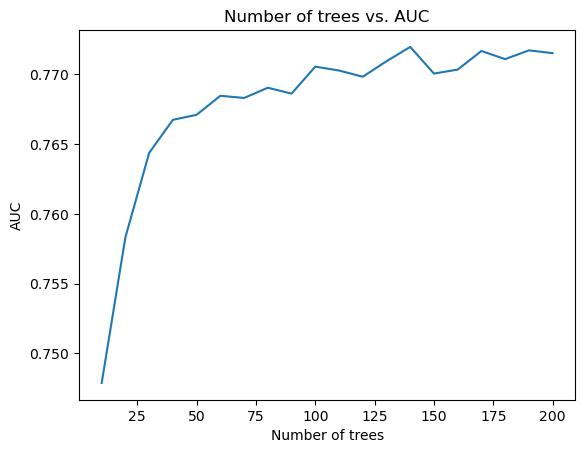

In [46]:
# Visualizing the n_estimatoes
plt.plot(df_aucs.n_estimator,df_aucs.auc)
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.title('Number of trees vs. AUC')

##### parameter tuning - Random forest
- `max_depth`
- `min_leaf_size`

In [47]:
auc_cal = {}

for depth in range(2,11,2):
    print(f'depth: {depth}')
    aucs = []
    for i in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=i,n_jobs=-1,max_depth=depth,random_state=1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)
        aucs.append((auc))
    auc_cal[depth] = aucs

depth: 2
depth: 4


KeyboardInterrupt: 

In [ ]:
auc_cal

{2: [0.7641107767928368,
  0.7719056974299345,
  0.7758337704831848,
  0.7775173586450852,
  0.7790847816830375,
  0.780466120110983,
  0.7794119399787949,
  0.7802146569038982,
  0.7805847138452174,
  0.7810134451947149,
  0.780487253102172,
  0.7804726100107399,
  0.780416241761909,
  0.780357638783445,
  0.7803549856797709,
  0.7804689262783306,
  0.7812608369080843,
  0.7815265962622749,
  0.7817459365064126,
  0.7816201079625437],
 4: [0.7834459228898683,
  0.7877258383072904,
  0.7901614691141181,
  0.7910697795654527,
  0.7904817497488122,
  0.78998012947799,
  0.7902113066462124,
  0.7899252918658943,
  0.7897972694093718,
  0.7895482144040835,
  0.7892754651421362,
  0.78918783108693,
  0.789377497386897,
  0.7893768137024887,
  0.7893239148969241,
  0.7894713254187578,
  0.789745319598583,
  0.7900484979188239,
  0.7901888062862066,
  0.7900954782623462],
 6: [0.7891881882355015,
  0.792334146734103,
  0.7928772370562012,
  0.7936439432010505,
  0.7932236813748204,
  0.792803

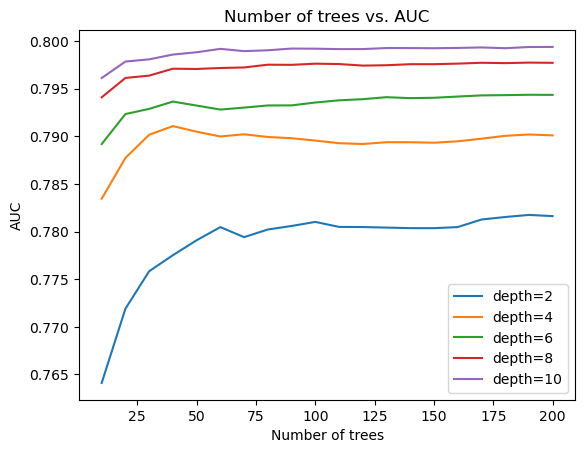

In [ ]:
n_trees = list(range(10,201,10))
for i,_ in auc_cal.items():
    plt.plot(n_trees,auc_cal[i],label='depth=%s'% i)
    plt.xlabel('Number of trees')
    plt.ylabel('AUC')
    plt.title('Number of trees vs. AUC')
    plt.legend()

Best `max_depth` = 10 with auc about `79.99%`

In [ ]:
auc_cal = {}

for m in [10,6,7]:
    print(f'min_samples_leaf: {m}')
    aucs = []
    for i in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=i,n_jobs=-1,max_depth=10,random_state=1,min_samples_leaf=m)
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)
        aucs.append((auc))
    auc_cal[m] = aucs

min_samples_leaf: 10
min_samples_leaf: 6
min_samples_leaf: 7


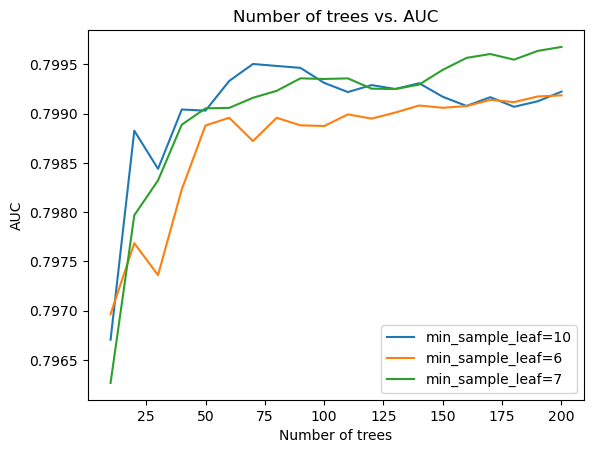

In [ ]:
n_trees = list(range(10,201,10))
for i in list(auc_cal.keys()):
    plt.plot(n_trees,auc_cal[i],label='min_sample_leaf=%s'% i)
    plt.xlabel('Number of trees')
    plt.ylabel('AUC')
    plt.title('Number of trees vs. AUC')
    plt.legend()

In [ ]:
df_aucs_rf = pd.DataFrame(auc_cal)
df_aucs_rf.sort_values(by=[10,6,7],ascending=False)

,10,6,7
6,0.799503,0.798721,0.799160
7,0.799483,0.798957,0.799231
8,0.799464,0.798880,0.799357
5,0.799331,0.798957,0.799058
9,0.799311,0.798874,0.799351
13,0.799308,0.799082,0.799294
11,0.799289,0.798949,0.799252
12,0.799249,0.799010,0.799249
19,0.799222,0.799185,0.799676
10,0.799218,0.798991,0.799357


Random Forest Parameters
- `max_depth` - 10
- `n_estimators` - 200
- `min_samples_leaf` - 6

In [ ]:
# Final Random Forest model
rf = RandomForestClassifier(n_estimators=200,n_jobs=-1,max_depth=10,random_state=1,min_samples_leaf=6)
rf.fit(X_train,y_train)
y_pred = rf.predict_proba(X_val)[:,1]

#### Gradient Boosting with XG-BOOST
I will combine multiple models together in an ensemble.

- `dtrain` - Training dataset
- `xgb_params` - Training parameters
- `num_boost_round`- Number of trees to train
- `evals` - Triggers the watchlist
- `verbose_eval` - How often the metric is printed

In [ ]:
dfulltrain = xgboost.DMatrix(X_full_train,label=y_full_train,feature_names=list(dv.get_feature_names_out()))
dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=list(dv.get_feature_names_out()))
dval = xgboost.DMatrix(X_val,label=y_val,feature_names=list(dv.get_feature_names_out()))
dtest = xgboost.DMatrix(X_test,label=y_test,feature_names=list(dv.get_feature_names_out()))

In [ ]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

In [ ]:
model = xgboost.train(xgb_params,dtrain,num_boost_round=10)

In [ ]:
y_pred = model.predict(dval)
roc_auc_score(y_val,y_pred)

0.7992486961424036

`watchlist = [(dtrain, 'train'), (dval, 'val')]`

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
%%capture output
model = xgboost.train(xgb_params,dtrain,num_boost_round=100,evals=watchlist,verbose_eval=10)

In [ ]:
def gradient_boost_output(output):
    data = []
    for i in output.stdout.split('\n'):
        if i:
            line = i.split('\t')
            round_num = int(line[0].strip('[]'))
            train_auc = float(line[1].split(":")[1])
            val_auc = float(line[2].split(":")[1])
            data.append((round_num, train_auc, val_auc))
    return data

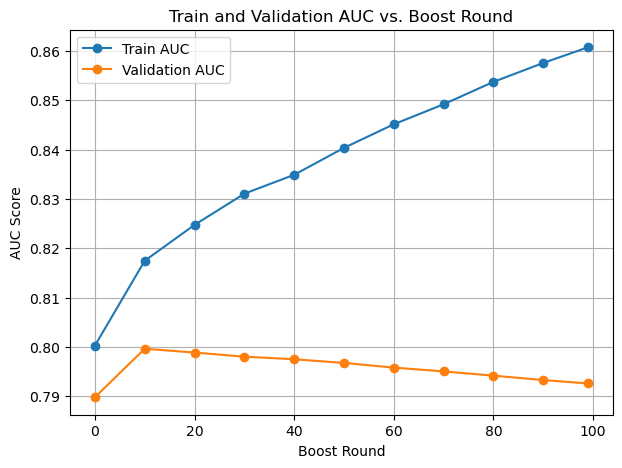

In [ ]:
# Convert to DataFrame
df_grad_boost = pd.DataFrame(gradient_boost_output(output), columns=["boost_round", "train_auc", "val_auc"])

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(df_grad_boost["boost_round"], df_grad_boost["train_auc"], label="Train AUC", marker='o')
plt.plot(df_grad_boost["boost_round"], df_grad_boost["val_auc"], label="Validation AUC", marker='o')
plt.xlabel("Boost Round")
plt.ylabel("AUC Score")
plt.title("Train and Validation AUC vs. Boost Round")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_grad_boost.sort_values(by=['val_auc'],ascending=False).head()

,boost_round,train_auc,val_auc
1,10,0.81746,0.79962
2,20,0.82473,0.79885
3,30,0.83105,0.79802
4,40,0.83488,0.79749
5,50,0.84034,0.79675


Each model in gradient boosting tries to fix mistakes of the previos boosting step. However, as seen in the validation scores above, the scores rise but then start to decline. This is an effect of `overfitting`.

##### XGBoost Parameter Tuning
Parameters of focus
- `eta` - Learning rate
- `max_depth` - Max allowed depth for each tree
- `min_child_weight` - minimum number of observations in each group == `min_leaf_size`

In [ ]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

##### **ETA** parameter tuning
- Values - [`0.05`,`0.1`,`0.2`,`0.3`]
- boost rounds - 500

In [ ]:
%%capture model_output_0_1
model = xgboost.train(xgb_params,dtrain,num_boost_round=500,evals=watchlist,verbose_eval=10)

In [ ]:
df_grad_boost_0_1 = pd.DataFrame(gradient_boost_output(model_output_0_1), columns=["boost_round", "train_auc", "val_auc"])
# Plotting
df_grad_boost_0_1.sort_values(by=['val_auc'],ascending=False).head()

,boost_round,train_auc,val_auc
4,40,0.82148,0.80020
6,60,0.82620,0.80019
7,70,0.82738,0.80016
8,80,0.82904,0.80000
3,30,0.81790,0.79998


Best **validation** AUC - 80.056 % for `auc = 0.1` after `50` iterations

In [ ]:
xgb_params = {
    'eta': 0.2,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

In [ ]:
%%capture model_output_0_2
model = xgboost.train(xgb_params,dtrain,num_boost_round=500,evals=watchlist,verbose_eval=10)

In [ ]:
df_grad_boost_0_2 = pd.DataFrame(gradient_boost_output(model_output_0_2), columns=["boost_round", "train_auc", "val_auc"])
# Plotting
df_grad_boost_0_2.sort_values(by=['val_auc'],ascending=False).head()

,boost_round,train_auc,val_auc
2,20,0.82112,0.79937
3,30,0.82554,0.79883
4,40,0.82773,0.79875
1,10,0.81401,0.79841
5,50,0.83126,0.79839


Best **validation** **AUC** - `80.006%` for `auc=0.2` after `30` iterations

In [ ]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

In [ ]:
%%capture model_output_0_0_5
model = xgboost.train(xgb_params,dtrain,num_boost_round=500,evals=watchlist,verbose_eval=10)

In [ ]:
df_grad_boost_0_0_5 = pd.DataFrame(gradient_boost_output(model_output_0_0_5), columns=["boost_round", "train_auc", "val_auc"])
# Plotting
df_grad_boost_0_0_5.sort_values(by=['val_auc'],ascending=False).head()

,boost_round,train_auc,val_auc
11,110,0.82441,0.80030
9,90,0.82258,0.80029
8,80,0.82112,0.80027
12,120,0.82535,0.80027
10,100,0.82357,0.80024


Best **validation AUC** - `80.082%` for `auc=0.05` after `130` iterations

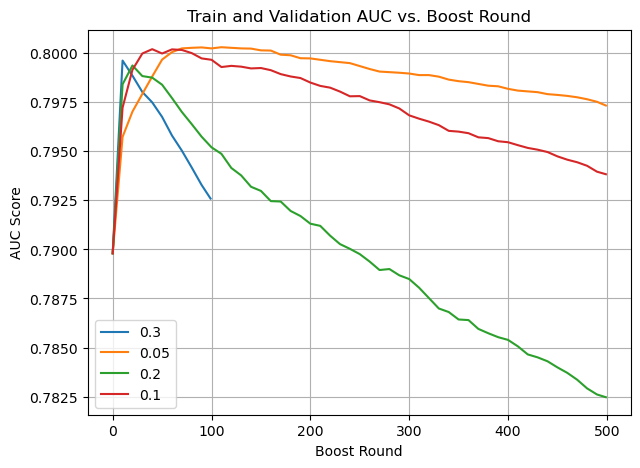

In [ ]:
# Plotting all 4 eta curves
plt.figure(figsize=(7, 5))
plt.plot(df_grad_boost["boost_round"], df_grad_boost["val_auc"], label="0.3")
plt.plot(df_grad_boost_0_0_5["boost_round"], df_grad_boost_0_0_5["val_auc"], label="0.05")
plt.plot(df_grad_boost_0_2["boost_round"], df_grad_boost_0_2["val_auc"], label="0.2")
plt.plot(df_grad_boost_0_1["boost_round"], df_grad_boost_0_1["val_auc"], label="0.1")
plt.xlabel("Boost Round")
plt.ylabel("AUC Score")
plt.title("Train and Validation AUC vs. Boost Round")
plt.legend()
plt.grid(True)
plt.show()

- `eta=0.1` presents `80.056%` after `50` iterations
- `eta=0.05` presents `80.082%` after `130` iterations
- `eta=0.2` presents`80.006%` after `30` iterations
- `eta=0.3` presents `79.950%` after `20` iterations

**Findings**
- eta of `0.05` presents almost similar results to eta of `0.2` but after `70` more iterations
- eta of `0.3` presents the least result of all.

### `max_depth`, `eta`, `min_child_weight` gradient boost parameters combined

In [ ]:
val_aucs  = []

etas = [0.05, 0.1, 0.2, 0.3]
max_depths = [4, 5, 6]
min_child_weights = range(15,17,1)

for eta in etas:
    for depth in max_depths:
        for min_child_weight in min_child_weights:
            xgb_params = {
                'eta': eta,
                'max_depth': depth,
                'min_child_weight': min_child_weight,
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'seed': 1,
            }
            
             # Capture model output
            f = io.StringIO()
            with contextlib.redirect_stdout(f):
                model = xgboost.train(xgb_params,dtrain,num_boost_round=200,evals=watchlist,verbose_eval=10)
        
            # Extract AUC values from the captured output
            output = f.getvalue().splitlines()
            depth_val_aucs = []
            for line in output:
                match = re.search(r"\[(\d+)\]\s+train-auc:[0-9.]+\s+val-auc:([0-9.]+)", line)
                if match:
                    boost_round = int(match.group(1))
                    val_auc = float(match.group(2))
                    depth_val_aucs.append((boost_round, val_auc))
            
            # Store AUCs and depth information in aucs list
            val_aucs.append({
                "eta": eta,
                "depth": depth,
                "min_child_weight": min_child_weight,
                "val_auc": depth_val_aucs
            })

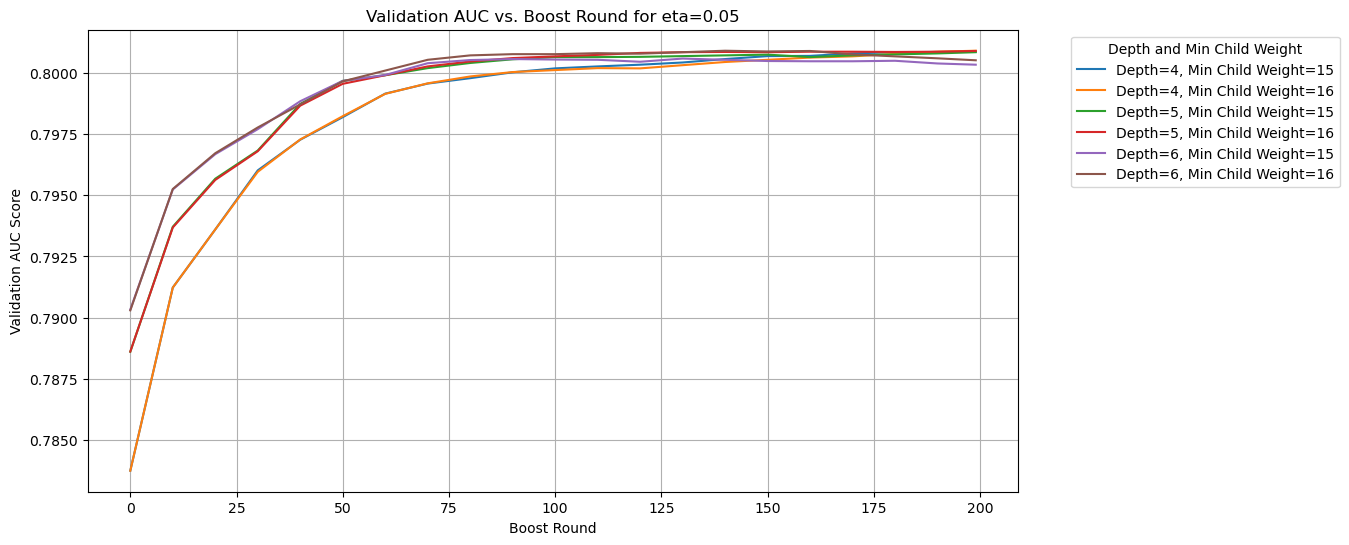

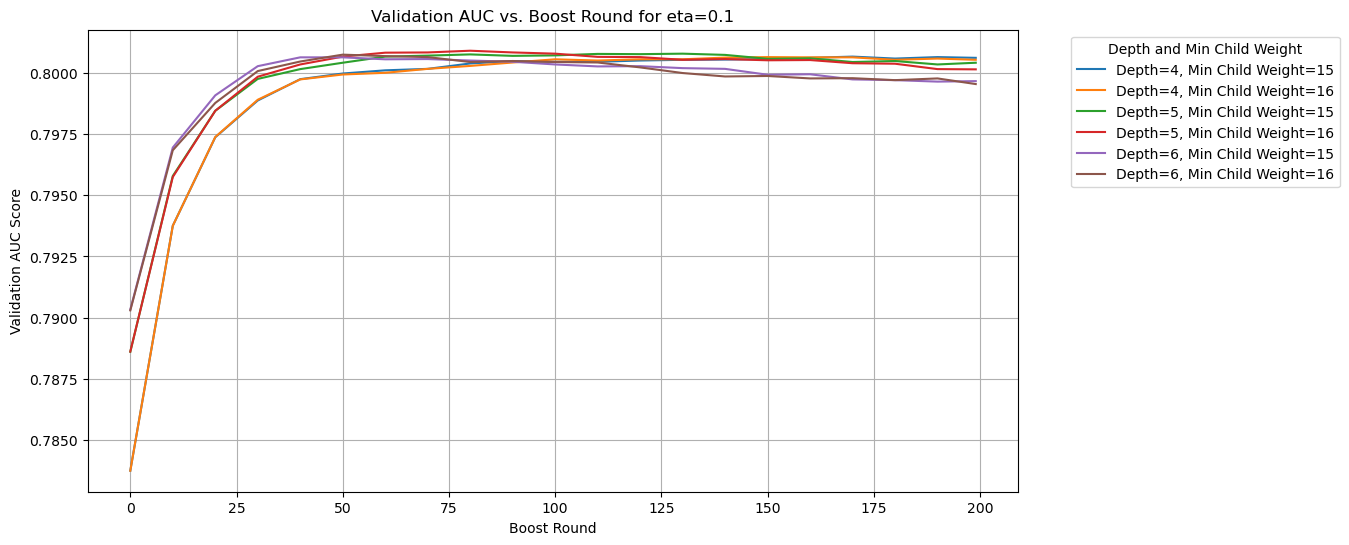

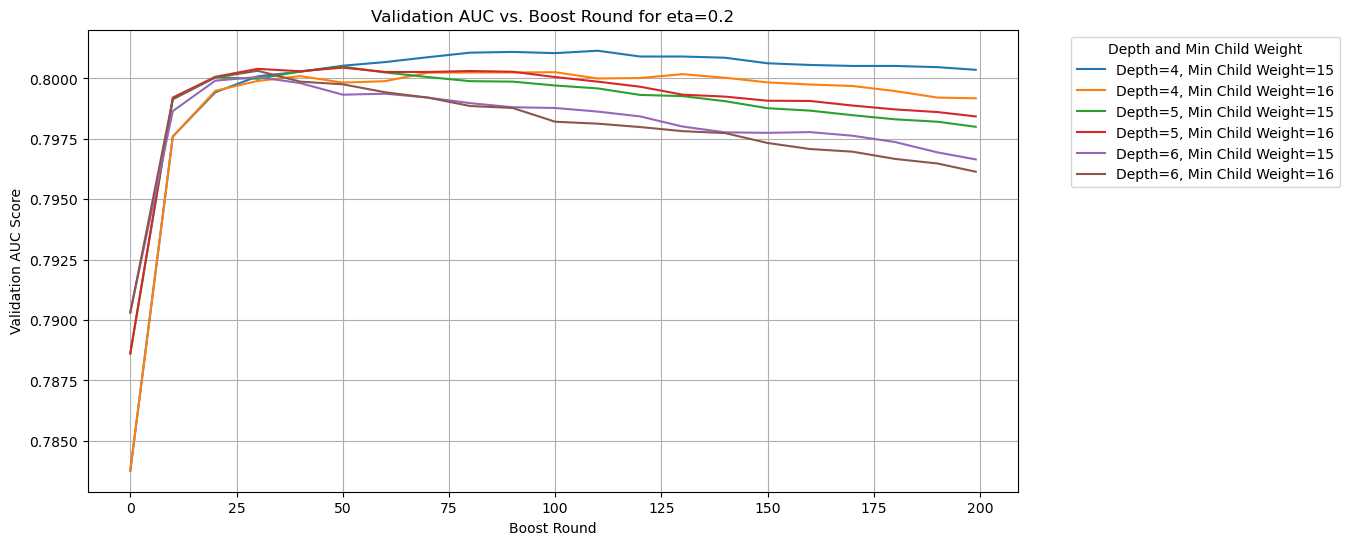

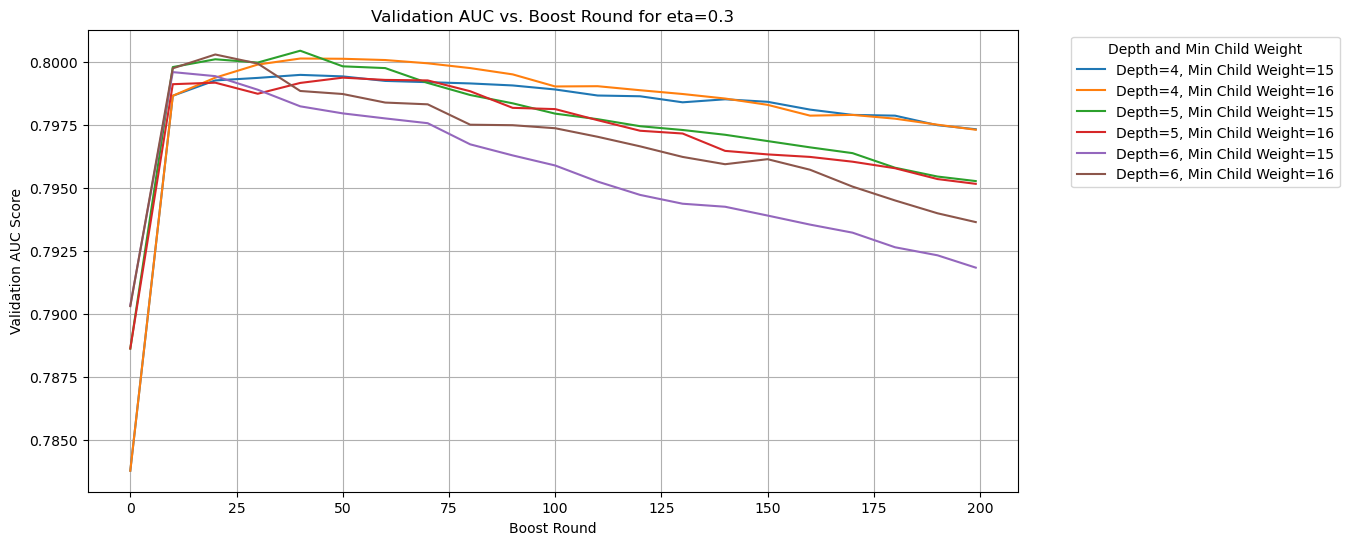

In [ ]:
plot_data = []
for entry in val_aucs:
    eta = entry["eta"]
    depth = entry["depth"]
    min_child_weight = entry["min_child_weight"]
    
    for boost_round, val_auc in entry["val_auc"]:
        plot_data.append((eta,depth,min_child_weight, boost_round, val_auc))

df_boost_depth = pd.DataFrame(plot_data, columns=["eta", "depth","min_child_weight", "boost_round", "val_auc"])

# Plotting
for eta in etas:
    plt.figure(figsize=(12, 6))
    subset_eta = df_boost_depth[df_boost_depth['eta'] == eta]
    for depth in subset_eta['depth'].unique():
        for min_child_weight in subset_eta['min_child_weight'].unique():
            subset = subset_eta[(subset_eta['depth'] == depth) & (subset_eta['min_child_weight'] == min_child_weight)]
            if not subset.empty:  # Ensure there's data to plot
                plt.plot(subset['boost_round'], subset['val_auc'], label=f"Depth={depth}, Min Child Weight={min_child_weight}")
    
    plt.xlabel("Boost Round")
    plt.ylabel("Validation AUC Score")
    plt.title(f"Validation AUC vs. Boost Round for eta={eta}")
    plt.legend(title="Depth and Min Child Weight", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.show()

In [ ]:
df_boost_depth.sort_values('val_auc',ascending=False)

,eta,depth,min_child_weight,boost_round,val_auc
263,0.20,4,15,110,0.80115
261,0.20,4,15,90,0.80110
260,0.20,4,15,80,0.80107
262,0.20,4,15,100,0.80105
264,0.20,4,15,120,0.80091
...,...,...,...,...,...
273,0.20,4,16,0,0.78376
147,0.10,4,16,0,0.78376
126,0.10,4,15,0,0.78376
21,0.05,4,16,0,0.78376


Best **Gradient Boost Model** - `80.147%`
- `eta` - 0.1
- `depth` - 5
- `min_child_weight` - 16
- `boost_round` - 140

## Final Models
- Final model choice after parameter tuning

In [ ]:
def evaluate_model(y_test, y_pred, y_pred_proba, model_name):
    # AUC-ROC Score
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} - AUC-ROC Score: {auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} - Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1 Score
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

### Models

In [ ]:
# Decision tree
clf_dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=172)
clf_dt.fit(X_full_train,y_full_train)
y_pred_dt = clf_dt.predict(X_test)
y_pred_proba_dt = clf_dt.predict_proba(X_test)[:,1]

In [ ]:
# Final Random Forest model
clf_rf = RandomForestClassifier(n_estimators=200,n_jobs=-1,max_depth=10,random_state=1,min_samples_leaf=6)
clf_rf.fit(X_full_train,y_full_train)
y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = clf_rf.predict(X_test)

### Final Evaluations of the models

Decision Tree - AUC-ROC Score: 0.7967


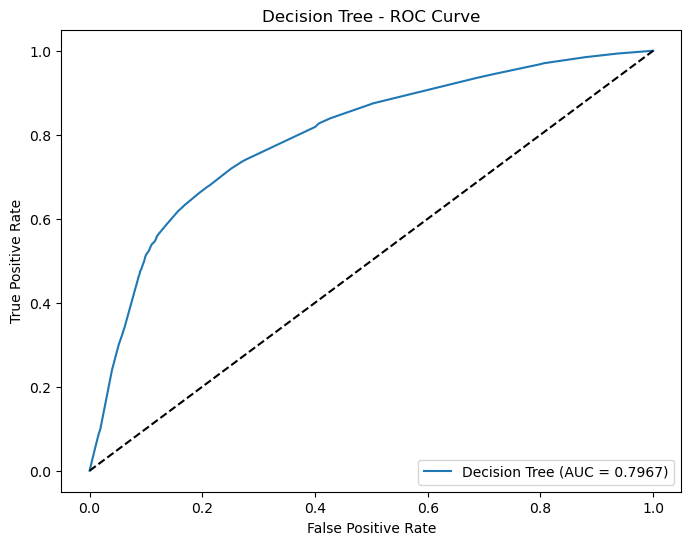

Decision Tree - Accuracy: 0.7329

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.79      0.75      6917
           1       0.77      0.68      0.72      7083

    accuracy                           0.73     14000
   macro avg       0.74      0.73      0.73     14000
weighted avg       0.74      0.73      0.73     14000



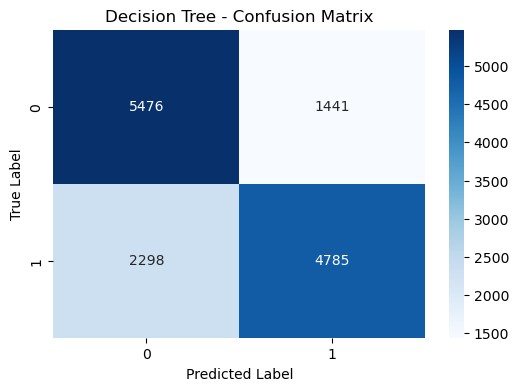

In [ ]:
# For Decision Tree
evaluate_model(y_test, y_pred_dt, y_pred_proba_dt, "Decision Tree")

Random Forest - AUC-ROC Score: 0.8036


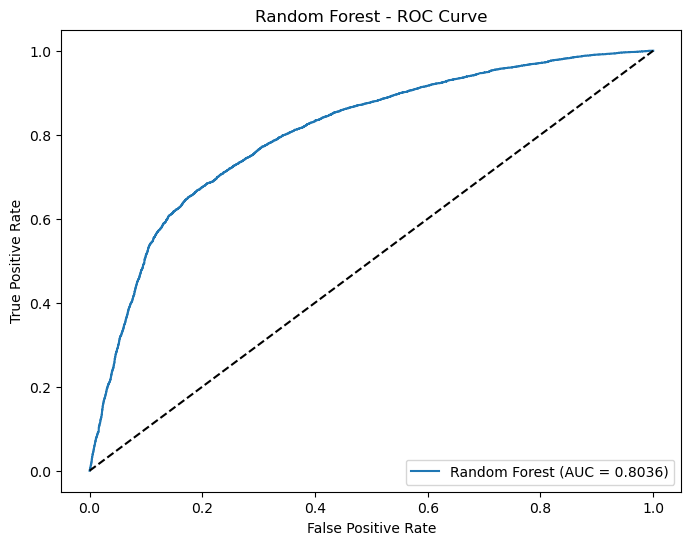

Random Forest - Accuracy: 0.7378

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6917
           1       0.78      0.68      0.72      7083

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000



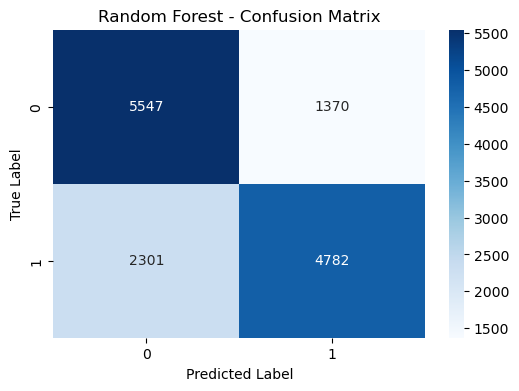

In [ ]:
# For Random Forest
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest")

In [ ]:
%%capture
xgb_params = {
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 16,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

model = xgboost.train(xgb_params,dfulltrain,num_boost_round=500,evals=watchlist,verbose_eval=10)

XGBoost - AUC-ROC Score: 0.8030


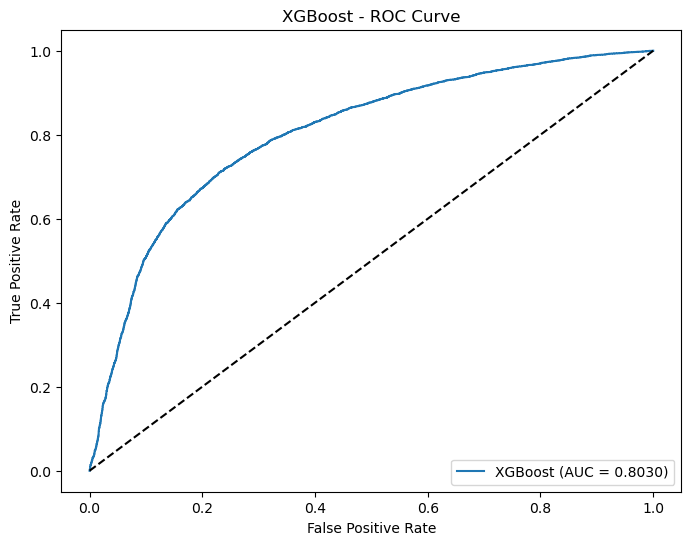

XGBoost - Accuracy: 0.7383

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6917
           1       0.76      0.70      0.73      7083

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000



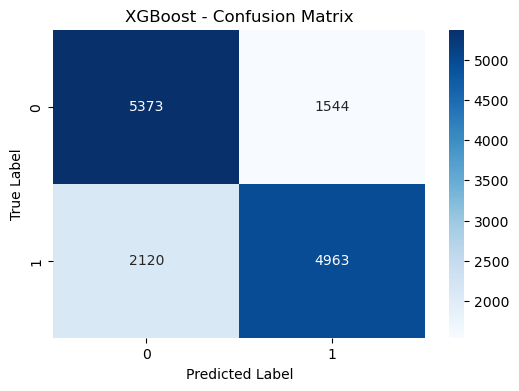

In [ ]:
y_pred_proba_xgb = model.predict(dtest)
y_pred_xgb = (y_pred_proba_xgb > 0.5).astype(int)

evaluate_model(y_test,y_pred_xgb,y_pred_proba_xgb,"XGBoost")

Sample out test subjects from df_test

In [ ]:
data = df.sample().to_dict(orient='records')[0]
data

{'age': 15266,
 'gender': 'male',
 'height': 1.87,
 'weight': 102.0,
 'ap_hi': 130,
 'ap_lo': 80,
 'cholesterol': 'normal',
 'gluc': 'normal',
 'smoke': 'no',
 'alco': 'no',
 'active': 'yes',
 'cardio': 0,
 'bmi': 29.1687}

In [ ]:
import requests

payload = {'age': 15327,
 'gender': 'female',
 'height': 168,
 'weight': 98.0,
 'ap_hi': 150,
 'ap_lo': 99,
 'cholesterol': 'above_normal',
 'gluc': 'normal',
 'smoke': 'no',
 'alco': 'no',
 'active': 'no'
 }

res = requests.post('http://localhost:5050/',json=payload)
res.raise_for_status()

res.json()

{'prediction': 0.9076,
 'cardio': True,
 'prediction%': '90.75999999999999%',
 'threshold': 0.5}